## Basic 'autoqtl' tutorial/demo
In this jupyter notebook we demonstrate how to run autoqtl using a sample dataset. 
The sample dataset consists of 28 features and a continuous phenotype as the target. 
The sample datat can be found at "https://github.com/EpistasisLab/autoqtl/tree/master/tutorials/data"

### STEP 1 - Import all the required packages and classes

In [3]:
import pandas as pd # for data loading and manipulation
from sklearn.model_selection import train_test_split # for splitting the datasets as required
import matplotlib.pyplot as plt # for visualization

from autoqtl import AUTOQTLRegressor # for running autoqtl

### STEP 2 - Load the sample data and make the required data splits

In [4]:
# read the sample data
data = pd.read_csv("/Users/ghosha/Documents/VSCode Projects/autoqtl/tutorials/sample_data.csv") # change the data path as required

# extract the features and target
features = data.iloc[:,:-1] # all the columns except the last column
target = data.iloc[:,-1] # the last column

# split the data into 80-20, use 20 as holdout and 80 for running autoqtl
features_80, features_20, target_80, target_20 = train_test_split(features, target, test_size=0.2, random_state=42)

### STEP 3 - Define autoqtl object using the AUTOQTLRegressor class.
The following parametrs can be set as required:

generations: int or None, optional (default: 100)
            Number of iterations to the run pipeline optimization process.
            It must be a positive number or None. If None, the parameter
            max_time_mins must be defined as the runtime limit.
            Generally, AutoQTL will work better when you give it more generations (and
            therefore time) to optimize the pipeline but it also depends on the complexity of the data. AutoQTL will evaluate
            POPULATION_SIZE + GENERATIONS x OFFSPRING_SIZE pipelines in total.
        
        population_size: int, optional (default: 100)
            Number of individuals to retain in the GP population every generation.
            Generally, AutoQTL will work better when you give it more individuals
            (and therefore time) to optimize the pipeline. AUTOQTL will evaluate
            POPULATION_SIZE + GENERATIONS x OFFSPRING_SIZE pipelines in total.
        
        offspring_size: int, optional (default: None)
            Number of offspring to produce in each GP generation.
            By default, offspring_size = population_size.
        
        mutation_rate: float, optional (default: 0.9)
            Mutation rate for the genetic programming algorithm in the range [0.0, 1.0].
            This parameter tells the GP algorithm how many pipelines to apply random
            changes to every generation. We recommend using the default parameter unless
            you understand how the mutation rate affects GP algorithms.
        
        crossover_rate: float, optional (default: 0.1)
            Crossover rate for the genetic programming algorithm in the range [0.0, 1.0].
            This parameter tells the genetic programming algorithm how many pipelines to
            "breed" every generation. We recommend using the default parameter unless you
            understand how the mutation rate affects GP algorithms.
        
        scoring: string or callable, optional
            Function used to evaluate the quality of a given pipeline for the
            problem. By default, coeeficient of determination (r^2) is used for regression problems.
            Other built-in Regression metrics that can be used:
            ['neg_median_absolute_error', 'neg_mean_absolute_error',
            'neg_mean_squared_error', 'r2']
        
        subsample: float, optional (default: 1.0)
            Subsample ratio of the training instance. Setting it to 0.5 means that AutoQTL
            randomly collects half of training samples for pipeline optimization process.
        
        
        max_time_mins: int, optional (default: None)
            How many minutes AutoQTL has to optimize the pipelines (basically how long will the generational process continue).
            If not None, this setting will allow AutoQTL to run until max_time_mins minutes
            elapsed and then stop. AutoQTL will stop earlier if generationsis set and all
            generations are already evaluated.
        
        max_eval_time_mins: float, optional (default: 5)
            How many minutes AutoQTL has to optimize a single pipeline.
            Setting this parameter to higher values will allow AutoQTL to explore more
            complex pipelines, but will also allow AutoQTL to run longer.
        
        random_state: int, optional (default: None)
            Random number generator seed for AutoQTL. Use this parameter to make sure
            that AutoQTL will give you the same results each time you run it against the
            same data set with that seed.
        
        config_dict: a Python dictionary or string, optional (default: None)
            Python dictionary:
                A dictionary customizing the operators and parameters that
                AutoQTL uses in the optimization process.
                For examples, see config_regressor.py 
            Path for configuration file:
                A path to a configuration file for customizing the operators and parameters that
                AutoQTL uses in the optimization process.
                For examples, see config_regressor.py 
        
        template: string (default: None)
            Template of predefined pipeline structure. The option is for specifying a desired structure
            for the machine learning pipeline evaluated in AutoQTL. So far this option only supports
            linear pipeline structure. Each step in the pipeline should be a main class of operators
            (Selector, Transformer or Regressor) or a specific operator
            (e.g. SelectPercentile) defined in AutoQTL operator configuration. If one step is a main class,
            AutoQTL will randomly assign all subclass operators (subclasses of SelectorMixin,
            TransformerMixin or RegressorMixin in scikit-learn) to that step.
            Steps in the template are delimited by "-", e.g. "SelectPercentile-Transformer-Regressor".
            By default value of template is None, AutoQTL generates tree-based pipeline randomly.
        
        warm_start: bool, optional (default: False)
            Flag indicating whether the AutoQTL instance will reuse the population from
            previous calls to fit().
        
        memory: a Memory object or string, optional (default: None)
            If supplied, pipeline will cache each transformer after calling fit. This feature
            is used to avoid computing the fit transformers within a pipeline if the parameters
            and input data are identical with another fitted pipeline during optimization process.
            String 'auto':
                AutoQTL uses memory caching with a temporary directory and cleans it up upon shutdown.
            String path of a caching directory
                AutoQTL uses memory caching with the provided directory and AutoQTL does NOT clean
                the caching directory up upon shutdown. If the directory does not exist, AutoQTL will
                create it.
            Memory object:
                AutoQTL uses the instance of joblib.Memory for memory caching,
                and AutoQTL does NOT clean the caching directory up upon shutdown.
            None:
                AutoQTL does not use memory caching.

        periodic_checkpoint_folder: path string, optional (default: None)
            If supplied, a folder in which AutoQTL will periodically save pipelines in pareto front so far while optimizing.
            Currently once per generation but not more often than once per 30 seconds.
            Useful in multiple cases:
                Sudden death before AutoQTL could save optimized pipeline
                Track its progress
                Grab pipelines while it's still optimizing
        
        early_stop: int or None (default: None)
            How many generations AutoQTL checks whether there is no improvement in optimization process.
            End optimization process if there is no improvement in the set number of generations.
        
        verbosity: int, optional (default: 0)
            How much information AutoQTL communicates while it's running.
            0 = none, 1 = minimal, 2 = high, 3 = all.
            A setting of 2 or higher will add a progress bar during the optimization procedure.
        
        log_file: string, io.TextIOWrapper or io.StringIO, optional (defaul: sys.stdout)
            Save progress content to a file.

We recommend setting the parameters, population_size, generations and verbosity.

In [11]:
# Initializing the autoqtl object using the AUTOQTLRegressor class
# For a sample run we set population_size to 100, generations to 5 and verbosity to 3 to get more details.
autoqtl_object = AUTOQTLRegressor(population_size=100, generations=5, verbosity=3, random_state=42)

### STEP 4 - Call the 'fit' function using the above defined object.
We call the fit function by passing the 80% of the data, a random seed and the test size to be used by autoqtl.
When executing the fit function, autoqtl further splits the data into a training-testing split to build models and perform internal validation. Thus the test_size parameter is used to
determine the size of the test dataset.

In [12]:
# calling the fit function
autoqtl_object.fit(features= features_80, target= target_80, random_state= 42, test_size= 0.5)

11 operators have been imported by AutoQTL.
Optimization Progress:  16%|█▋        | 98/600 [00:08<00:54,  9.16pipeline/s] 
Entered Generation:  1
                                                                              
Generation 1 - Current Pareto Front:
                                                                              
Test R^2 = 0.19339373223165968,	Difference Score = 1.2792266534469467,	Pipeline: RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.1, RandomForestRegressor__min_samples_leaf=3, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)
                                                                              
Test R^2 = 0.18738903623585934,	Difference Score = 1.3980210731253029,	Pipeline: RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=True, RandomForestRegressor__max_features=0.2, RandomForestRegressor__min_samples_leaf=5, RandomForestRe

AUTOQTLRegressor(generations=5, random_state=42, verbosity=3)

While running the 'fit' function the progress can be viewed with the help of the progress bar.
The Pareto front at the end of each geenration is displayed and finally the final Pareto front is displayed at the end of 'n' (defined by user in the AUTOQTLRegressor class) generations.

### STEP 5 - Calling the get_final_output(..) function to get a consolidated pdf file.
After calling the 'fit' function, we recommend calling the get_final_output(...) function to get the results of the final Pareto front, the Pareto front plot and the average SHAP feature importance plot in a consolidated pdf file.
We call this function by passing the entire dataset, the holdout dataset and the path of the output file.
The file final_output.pdf will be saved in the provided path along with a text version.
Running this function maybe time consuming due to execution of SHAP feature importance. 

In [13]:
# calling the get_final_output(...) function
autoqtl_object.get_final_output(features, target, features_20, target_20, file_path = '/Users/ghosha/Library/CloudStorage/Box-Box/AutoQTL/Mouse Data/Analysis/AutoQTL Outputs/') # change path as required.

Permutation explainer: 1524it [03:47,  6.45it/s]                          
Permutation explainer: 1524it [03:19,  7.25it/s]                          
Permutation explainer: 1524it [03:06,  7.72it/s]                          
Permutation explainer: 1524it [03:17,  7.34it/s]                          
Permutation explainer: 1524it [03:11,  7.54it/s]                          
Permutation explainer: 1524it [03:07,  7.68it/s]                          
Permutation explainer: 1524it [02:57,  8.08it/s]                          
Permutation explainer: 1524it [03:01,  7.92it/s]                          
Permutation explainer: 1524it [02:53,  8.29it/s]                          
Permutation explainer: 1524it [02:52,  8.31it/s]                          
Permutation explainer: 1524it [02:46,  8.62it/s]                          
Permutation explainer: 1524it [02:43,  8.76it/s]                          
Permutation explainer: 1524it [00:20, 37.51it/s]                          
Permutation explainer: 15

<Figure size 640x480 with 0 Axes>

### Other optional steps

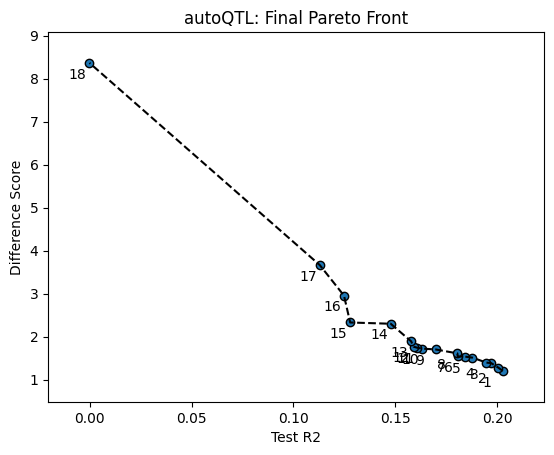

In [14]:
# Display the Pareto plot
plot = autoqtl_object.plot_final_pareto()
plot.show()

In [16]:
# Get the holdout score on a chosen pipeline by looking at the Pareto plot
autoqtl_object.score_user_choice(features_20, target_20, 15)

0.07753439911638327

Permutation explainer: 1524it [03:55,  6.19it/s]                          
The figure layout has changed to tight


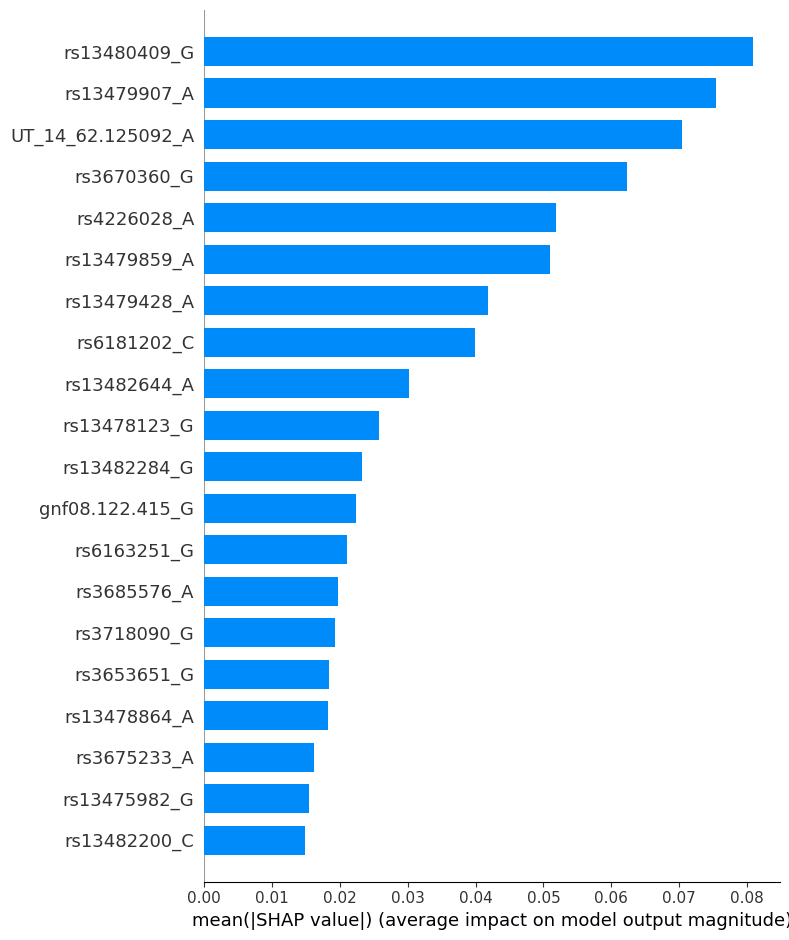

In [18]:
# Get the SHAP feature importance based on a chosen pipeline by looking at the Pareto plot
plot = autoqtl_object.shap_feature_importance_user_choice(features, target, 15)
plot.show()